# nested

In [1]:
import numpy as np
import scipy.linalg as la
import scipy.sparse as sparse
import matplotlib.pyplot as plt
import torch
from sympy.utilities.iterables import multiset_permutations
import pickle

import time
tStart_notebook = time.time()

import sys
sys.path.insert(0, '../source')

from source.FomShallowIce import FomShallowIce
from source.PolyRomIntrusiveShallowIce import PolyRomIntrusiveShallowIce
from source.FoodReprojectionTime import FoodReprojectionTime
from source.FoodTime import FoodTime
import source.comparisons as testing
from source.ConstrainedOpInf import ConstrainedOpInf
from source.SnapshotTransformer import SnapshotTransformerExtension as SnapshotTransformer
#from fom.FomShallowIce_approx8 import FomShallowIce_approx8
from source.NestFire import NestFire
from source.ConstrainedOpInf import ConstrainedOpInf

import opinf as opinf

import source.helpers_polyMat as polyMat
import source.helpers_opinf as helpers_opinf
import source.solvers as solvers

## User settings

## Setup

In [2]:
with open('data/RB_slicer1', 'rb') as handle:
    [transformer, U_train, VR, nRB, slicer] = pickle.load(handle)

In [3]:
nRB = 7
VR = VR[:, :nRB]

In [4]:
fom = FomShallowIce(Lx=1000, 
                    Lz=1, 
                    orders=[511], 
                    bc_type="N", 
                    dt=1e-3, 
                    init_time=0, 
                    final_time=2)

# fom = FomShallowIce_approx8(Lx=1000, 
#                     Lz=1, 
#                     orders=[511], 
#                     bc_type="N", 
#                     dt=1e-3, 
#                     init_time=0, 
#                     final_time=10)

U_dot = opinf.pre.ddt(U_train, fom.dt, order=2)
U_dot_proj = VR.T @ U_dot

U_proj = VR.T @ U_train

matrixhandler = FoodReprojectionTime(VR, fom, transformer=transformer)
matrixhandler.set_data(snapshots = [U_train], source = [U_dot_proj.T], slicer = 1)

In [5]:
U_train_proj = VR.T @ U_train

In [6]:
matrixhandler.D.shape

(2001, 3087)

## Helper functions

In [7]:
def subspacelearning(indexset, inferred, K_add, index_tracker, D_ex, R_ex):
    
    # initialize
    D_I = matrixhandler.get_data_matrix(indices=indexset)
    known = matrixhandler.blow_down(indices = indexset, 
                                    big_matrix = inferred, 
                                    indices_testspace=[*range(nRB)], 
                                    nRB=nRB)
    adjustment = D_I @ known
    expansion = np.zeros((D_I.shape[1], nRB))
    
    # find out which column entries are already known
    known_indices = matrixhandler.blow_down(indices = indexset, 
                                    big_matrix = index_tracker, 
                                    indices_testspace=[0], 
                                    nRB=nRB)
    subindices = np.where(known[:, 0] == 0)[0]
    
    # remove known columns
    D_I = D_I[:, subindices]
    
    # remove columns that are too close to zero
    norms = la.norm(D_I, axis = 0, ord = np.infty)
    large_enough = np.where(norms > 1e-10 * np.max(norms))[0]
    large_enough = large_enough[np.where(norms[large_enough] > 1e-10)[0]]
    subindices = subindices[large_enough]
    D_I = D_I[:, large_enough]
    
    if D_I.shape[1] > 0:
    
        # identify most linearly independent rows
        Q, R, P = la.qr(D_I.T, pivoting=True)
        P = P[:D_I.shape[1] + 5]
        D_I = D_I[P, :]
        
        # check condition number for D_I
#         U, svals, Vt = la.svd(D_I)
#         cond = svals[0] / svals[-1]
#         print("condition number: ", cond)
        
        # which reduced space are we working on btw?
        V_I = VR[:, indexset]
        R_I = np.zeros((np.min([P.shape[0], K_add]), nRB))
        
        # compute snapshot derivatives
        for k in range(np.min([P.shape[0], K_add])):
            s = V_I @ U_train_proj[indexset, P[k]]
            reprojection = transformer.inverse_transform(s)
            rhs = fom.apply_governing_eq(np.array([reprojection]).T, para=matrixhandler.Xi_train[0, :])
            rhs = transformer.transform(rhs).T @ VR
            R_I[k, :] = rhs
            
        # don't try to learn new entries if there's not enough data
        if K_add < P.shape[0]:
            print("not enough budget left")
            return False, inferred, 0, index_tracker, D_ex, R_ex
        
        # adjust our remaining budget
        K_add -= P.shape[0]
        
        # solve least squares problem
        learned = solvers.lstsq_truncSVD(D=D_I, 
                                         R=R_I-adjustment[P, :], 
                                         cutoff=1e-8, 
                                         bool_rescale=True, 
                                         bool_relative_cutoff=False)
        expansion[subindices, :] = learned
        
        # save D_I and R_I for the final least squares problem
        D_large = matrixhandler.get_data_matrix(indices=indexset)
        D_large = D_large[P, :]
        D_large = matrixhandler.blow_up(indices=indexset, 
                                                  A_sub=D_large.T, 
                                                  new_shape=(D_ex.shape[1], D_large.shape[0]), 
                                                  indices_testspace=[*range(D_large.shape[0])], nRB=nRB)   
        D_ex = np.vstack([D_ex, D_large.T])
        R_ex = np.vstack([R_ex, R_I])
    
    # save the entries we just learned at the correct position
    expansion = matrixhandler.blow_up(indices=indexset, 
                                              A_sub=expansion, 
                                              new_shape=inferred.shape, 
                                              indices_testspace=[*range(nRB)])   
    inferred = inferred + expansion
    
    # remember which entries we've learned for the future
    known_indices[:, 0] = 1
    known_indices = matrixhandler.blow_up(indices=indexset, 
                                              A_sub=known_indices, 
                                              new_shape=index_tracker.shape, 
                                              indices_testspace=[0])
    index_tracker = index_tracker + known_indices
    
    
    
    return True, inferred, K_add, index_tracker, D_ex, R_ex

## Nested OpInf
as described in the CDC paper

In [8]:
tStart = time.time()

D_R = matrixhandler.D
R_R = matrixhandler.R

K_add = matrixhandler.D.shape[0]
inferred = np.zeros(matrixhandler.get_shape(n=nRB))
index_tracker = np.zeros((D_R.shape[1], 1), dtype=int)

D_ex = np.zeros((0, D_R.shape[1]))
R_ex = np.zeros((0, nRB))

# sanity check
R_e = matrixhandler.get_rhs_matrix(indices = [*range(nRB)], indices_testspace=[*range(nRB)])
print("sanity check:", la.norm(R_R - R_e, axis = 0, ord=np.infty))

for r in range(nRB):
    for d in range(1, r+2):
        subsets = helpers_opinf.get_all_subsets_of_size([*range(r)], d-1)
        for sub in subsets:
            indexset = sub + [r]
            #print("current indexset:", indexset, K_add)
            
            bool_expanded, inferred, K_add, index_tracker, D_ex, R_ex = subspacelearning(indexset, 
                                                                             inferred, 
                                                                             K_add, 
                                                                             index_tracker, D_ex, R_ex)
            
            if K_add <= 0:
                break
            
            if bool_expanded is False:
                break
                
        if K_add <= 0:
                break
            
        if bool_expanded is False:
            break
    
    if K_add <= 0:
        break
        
print("runtime for this block: ", time.time()-tStart, "s.")

sanity check: [0.00429586 0.0110022  0.01168178 0.01254524 0.0071722  0.0160791
 0.00578659]
runtime for this block:  2.9706075191497803 s.


In [9]:
D = np.vstack([D_R, D_ex])
R = np.vstack([R_R, R_ex])

# opinf_helper = ConstrainedOpInf(matrixhandler=matrixhandler)
# weights = opinf_helper.get_weights([1, 1], 1e-3)
# weights = np.hstack([weights, 1e-3 * np.ones(D_ex.shape[0])])

weights = np.hstack([np.ones(D_R.shape[0]), 1e-4 * np.ones(D_ex.shape[0])])
D = (D.T / np.sqrt(weights)).T
R = (R.T / np.sqrt(weights)).T

D, R = polyMat.extend_for_regularization(D, 
                                         [*range(nRB)], 
                                         nRB, 
                                         fom.polyOrders, 
                                         fom.affineOrders, 
                                         [1e-3, 5e+4], 
                                         R=R - D @ inferred)

inferred_2 = solvers.lstsq_truncSVD(D=D, R=R, 
                                         cutoff=1e-10, 
                                         bool_rescale=True, 
                                         bool_relative_cutoff=False)

# inferred_2 = la.solve(D.T @ D, D.T @ R)

inferred_2 = inferred_2 + inferred

In [10]:
# tStart = time.time()
# grid_t = 1e-3*np.arange(2001)

# err_min = np.infty
# inferred_min = None

# for reg1 in np.logspace(-6, 6, 5): #np.logspace(-3, 2, 5):
#     for reg2 in np.logspace(0, 6, 5):
#         if reg1 <= reg2:
            
#             D = np.vstack([D_R, D_ex])
#             R = np.vstack([R_R, R_ex])

#             weights = np.hstack([np.ones(D_R.shape[0]), 1e-4 * np.ones(D_ex.shape[0])])
#             D = (D.T / np.sqrt(weights)).T
#             R = (R.T / np.sqrt(weights)).T

#             D, R = polyMat.extend_for_regularization(D, 
#                                                      [*range(nRB)], 
#                                                      nRB, 
#                                                      fom.polyOrders, 
#                                                      fom.affineOrders, 
#                                                      [reg1, reg2], 
#                                                      R=R - D @ inferred)

#             inferred_2 = solvers.lstsq_truncSVD(D=D, R=R, 
#                                                      cutoff=1e-10, 
#                                                      bool_rescale=True, 
#                                                      bool_relative_cutoff=False)
            
#             inferred_2 = inferred_2 + inferred

#             rom = matrixhandler.get_reduced_model(A_new = inferred_2, indices = [*range(nRB)])
#             sol_RB = rom.solve(grid_t=grid_t, para=[1], bool_explicit_euler=False)

#             if not np.isnan(sol_RB).any():
#                 Sol_RB = rom.toFO(sol_RB)
#                 error = la.norm(Sol_RB-U_train)

#                 if error < err_min:
#                     inferred_min = inferred_2
#                     err_min = error
                    
# print("runtime for this block: ", time.time()-tStart, "s.")

In [11]:
# R_test = matrixhandler.get_rhs_matrix(indices=[*range(nRB)])

# for i in range(nRB):
#     plt.semilogy(np.abs(R_test[:, i] - R_R[:, i]), label = "error")
# plt.semilogy(weights, label = "weights")

# plt.legend()

In [12]:
#la.norm(inferred_min-inferred, ord=np.infty)

In [13]:
#plt.semilogy(np.vstack([D_R, D_ex]) @ inferred_2[:, 0] - np.vstack([R_R, R_ex])[:, 0])

## testing

In [15]:
ROMq_nested = np.zeros(nRB, dtype = object)

for n in range(nRB):
    ROMq_nested[n] = matrixhandler.get_reduced_model(A_new = inferred, indices = [*range(n+1)])
    
ROMq_nested_2 = np.zeros(nRB, dtype = object)

for n in range(nRB):
    ROMq_nested_2[n] = matrixhandler.get_reduced_model(A_new = inferred_2, indices = [*range(n+1)])

# names = ["nested", "nested final", "projection"]
# list_ROMq = [ROMq_nested, ROMq_nested_2]

names = ["nested final", "projection"]
list_ROMq = [ROMq_nested_2]
    
with open('data/fom_1e-3', 'rb') as handle:
    [U, grid_t, final_time] = pickle.load(handle)

In [16]:
errors = testing.error_comparison(list_ROMq = list_ROMq, 
                                  list_U_test = [U], 
                                  grid_t = grid_t, 
                                  Xi_test = [None], 
                                  VR = VR)

r = 1: Online compute time: 3.494074821472168 s.
r = 2: Online compute time: 3.935091733932495 s.
r = 3: Online compute time: 3.9185245037078857 s.
r = 4: Online compute time: 4.004530191421509 s.
r = 5: Online compute time: 4.186920881271362 s.
r = 6: Online compute time: 4.344851732254028 s.
r = 7: Online compute time: 4.753669261932373 s.


figsize:  10 4


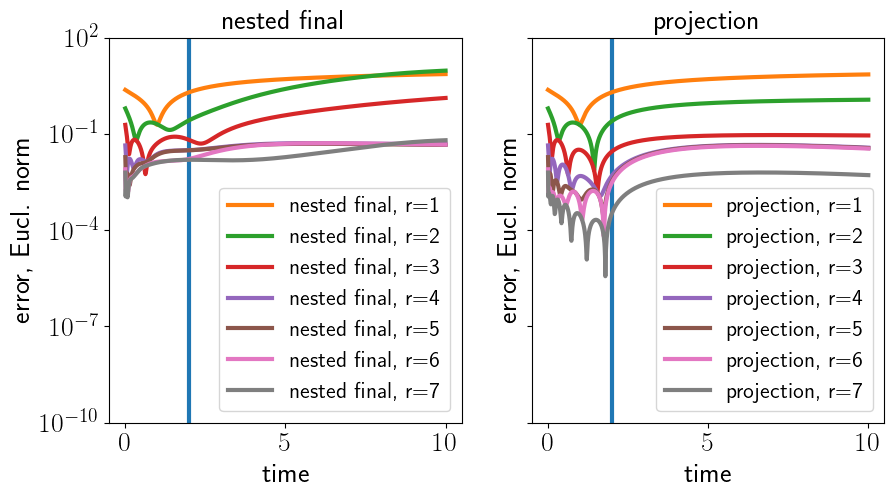

In [17]:
testing.plot_error_comparison_horizontal(errors = errors, 
                              model_indices = [*range(len(names))], 
                              error_indices = [0], 
                              para_index = 0, 
                              final_training_time = 2, 
                              grid_t = grid_t, 
                              names = names)

In [18]:
with open('data/nested_regularized_3', 'wb') as handle:
    pickle.dump(ROMq_nested_2, handle, protocol=pickle.HIGHEST_PROTOCOL)

## The End.

In [19]:
print("Runtime of this notebook: {} min".format((time.time()-tStart_notebook)/60))

Runtime of this notebook: 1.4481411854426065 min
